# Creditworthiness model: data exploration
This model will be built upon LendingClub data to evaluate an individual's credit worthiness. The data contains rows of customers, with each column showing the features for loan applications that have been approved, together with outcomes of the loans (in the final column).  The outcomes show that each customer has either defaulted or completed their loan.

#### Exploration steps
1. Address missing values
2. Understand data types, prepare for classifier
3. Understand feature profiles, idenfity anomalies
4. Assess dependent-independent variable relationships

## Data exploration
First I'll begin by exploring the dataset to understand the distribution of values (e.g. any skew), nuances, redundancies, collinearity, etc. I'll do this with the whole dataset (this shouldn't cause a data leak; rather a handy knowledge leak!).

In [1]:
# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import datetime

# Configuration
#colour_list = ['#b2df8a', '#1f78b4', '#a6cee3']
sns.set(font_scale=1.5)
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)
%matplotlib inline

fpath = './data/'
fname = 'data.csv'

df = pd.read_csv(fpath + fname, header=0)
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24776 entries, 0 to 24775
Data columns (total 21 columns):
Loan Amount                          24776 non-null int64
Loan Term                            24776 non-null object
Employment Length                    24776 non-null float64
Home Ownership                       24776 non-null object
Annual Income                        24776 non-null float64
Loan Purpose                         24776 non-null object
Address State                        24775 non-null object
Debt To Income Ratio                 24775 non-null float64
No. Delinquencies In Last 2 Years    24775 non-null object
Earliest Credit Line Opened          24776 non-null float64
FICO Credit Score                    24775 non-null float64
No. Inquiries In Last 6 Months       24775 non-null float64
Months Since Last Delinquency        24776 non-null int64
No. Of Credit Lines                  24775 non-null float64
No. Adverse Public Records           24775 non-null object
T

,Loan Amount,Loan Term,Employment Length,Home Ownership,Annual Income,Loan Purpose,Address State,Debt To Income Ratio,No. Delinquencies In Last 2 Years,Earliest Credit Line Opened,...,No. Inquiries In Last 6 Months,Months Since Last Delinquency,No. Of Credit Lines,No. Adverse Public Records,Total Credit Balance,Use Of Credit Line,Total Number Of Credit Lines,Loan Application Description,No. Of Public Record Bankruptcies,Class
0,25000,36 Months,0.5,RENT,85000,Debt Consolidation,CA,19.48,None,34380.44375,...,0,0,10,None,28854,52.1,42,308,None,Creditworthy
1,7000,36 Months,0.5,RENT,65000,Credit Card,NY,14.29,None,36820.52083,...,0,0,7,None,33623,76.7,7,71,None,Creditworthy


In [2]:
unique_counts = pd.Series({
            n: len(c.unique()) for n, c in df.iteritems() if c.dtype == np.object
        })
print(unique_counts.sort_values())

Class                                 2
Loan Term                             2
No. Of Public Record Bankruptcies     3
Home Ownership                        5
No. Adverse Public Records            6
No. Delinquencies In Last 2 Years    11
Loan Purpose                         15
Address State                        51
dtype: int64


* All of the columns appear relevant to creditworthiness and have >1 value, so I'll not remove any yet.
* Some of the columns contain less than 24776 values, which will need to be addressed.

### 1) Missing values
Below I shall determine why some columns do not have the full number of values.

In [3]:
incomplete_cols = [name for name, col in df.iteritems() if col.count() != len(df)]
print('Number of columns with null values: {}/{}'.format(len(incomplete_cols), len(df.columns)))
incomplete_rows = df[df.isnull().any(axis=1)]
print('Number of rows with null values: {}/{}\n'.format(len(incomplete_rows),len(df)))

# Check the count of nulls in each column
unique_counts = {n: c.isnull().sum() for n, c in incomplete_rows.iteritems()}
pprint(unique_counts)

# Remove index 7666 and try again
df = df.drop(df.index[7666])
incomplete_rows = df[df.isnull().any(axis=1)]
unique_counts = {n: c.isnull().sum() for n, c in incomplete_rows.iteritems()}
print('\nAfter removing index 7666:')
pprint(unique_counts)

Number of columns with null values: 10/21
Number of rows with null values: 52/24776

{'Address State': 1,
 'Annual Income': 0,
 'Class': 0,
 'Debt To Income Ratio': 1,
 'Earliest Credit Line Opened': 0,
 'Employment Length': 0,
 'FICO Credit Score': 1,
 'Home Ownership': 0,
 'Loan Amount': 0,
 'Loan Application Description': 0,
 'Loan Purpose': 0,
 'Loan Term': 0,
 'Months Since Last Delinquency': 0,
 'No. Adverse Public Records': 1,
 'No. Delinquencies In Last 2 Years': 1,
 'No. Inquiries In Last 6 Months': 1,
 'No. Of Credit Lines': 1,
 'No. Of Public Record Bankruptcies': 0,
 'Total Credit Balance': 1,
 'Total Number Of Credit Lines': 1,
 'Use Of Credit Line': 52}

After removing index 7666:
{'Address State': 0,
 'Annual Income': 0,
 'Class': 0,
 'Debt To Income Ratio': 0,
 'Earliest Credit Line Opened': 0,
 'Employment Length': 0,
 'FICO Credit Score': 0,
 'Home Ownership': 0,
 'Loan Amount': 0,
 'Loan Application Description': 0,
 'Loan Purpose': 0,
 'Loan Term': 0,
 'Months Since

It appears we have 52 incomplete rows, and 10 columns containing nulls. After removing the troublesome index 7666, this is reduced to 51 instances of null in one column: 'Use of Credit Line'. I'll attempt to interpolate these later given this is a numerical column. As this is a small proportion of the total dataset I'd be happy to remove them if this yields poor results, after checking whether they're predictive / clustered.

**To do: Impute 51 missing values in 'Use of Credit Line' column.**

### 2) Understand data types
I'd now like to see how each column is formatted in preparation for converting the data for input into the logistic regression. 

Overall, the conversions by column (this is an active list and has been updated from later work in this notebook):
* Numerical columns
 * Loan amount - don't change
 * Employment length - convert to dummies
 * Annual income - don't change
 * Debt to income ratio - don't change
 * Earliest credit line opened - convert to ordinal (days since 01/01/1900); see next section
 * FICO Credit Score - don't change 
 * No inquiries in last 6 months - don't change
 * Months since last delinquency - convert to dummies, via bins (0 -> NA); see next section
 * No of active credit lines - don't change
 * Total credit balance - don't change
 * Use of credit line - don't change
 * Total number of credit lines - don't change
 * Loan application description - convert to dummies
* Categorical columns
 * Loan term - convert to ordinal
 * Home ownership - convert to dummies
 * Loan purpose - convert to dummies
 * Address state - convert to dummies
 * No. delinquencies in last 2 years - convert to dummies, aggregate FourOrMore.
 * No. adverse public records - convert to ordinal
 * No. public record bankrupcies - convert to dummies, true/false.
 * Class - convert to dummies, true/false.

For *Class* we convert to a zero (uncreditworthy) or a one (creditworthy).

In [4]:
df['Class'] = df['Class'].map({'Uncreditworthy': 0, 'Creditworthy': 1})

*Employment Length* would be ordinal had the question not been capped at '10 years or more'. A quick check of the distributions of *Employment Length* by *Class* shows that the peaks are at the same number of years for both. As such, I'll use a discrete binning interval for this feature. 

It's worth noting that the length of employment is a complex feature: it should not be confused with salary or purchasing power as people move jobs frequently and different employment roles have different rates of change in salary. On its own, it is not indicative of creditworthiness. It can, however, suggest stability (if low, the individual could still be in a probationary period, for example). 

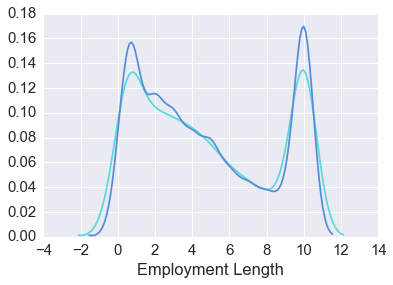

In [5]:
df_el_0 = df['Employment Length'].loc[df['Class'] == 0]
df_el_1 = df['Employment Length'].loc[df['Class'] == 1]

f, ax = plt.subplots()
sns.distplot(df_el_0, hist=False, ax=ax)
sns.distplot(df_el_1, hist=False, ax=ax)

df['Employment Length'] = pd.cut(x=df['Employment Length'], bins=11, labels=[x for x in range(11)])

For *Loan Term* we can simply take the months from the front of the string. As only 36 and 60 month options are present we can skip the regex and use slicing.

In [6]:
df['Loan Term'] = df['Loan Term'].map(lambda x: int(x[0:2]))

The *No. Delinquencies In Last 2 Years* is a little more complicated. The very low number of delinquencies beyond three of four means we're unlikely to learn much from these at the disaggregated level, so it would be best to group these together. In this case, the data is no longer ordinal: dummies will be used for this column. 

For *No. adverse public records* we use TwoOrMore aggregation.

For *No. Of Public Record Bankruptcies* we would use OneOrMore aggregation, so change this to a zero (no public record bankruptcies) or a one.

In [7]:
print('No. Delinquencies In Last 2 Years (before replace)')
print(df['No. Delinquencies In Last 2 Years'].value_counts())
dict_ndl2y = {'Three': 'ThreeOrMore', 
        'Four': 'ThreeOrMore', 
        'Five': 'ThreeOrMore', 
        'Six': 'ThreeOrMore',
        'Seven': 'ThreeOrMore',
        'Eight': 'ThreeOrMore', 
        'Nine': 'ThreeOrMore'
        }
df['No. Delinquencies In Last 2 Years'].replace(dict_ndl2y, inplace=True)

print('No. Adverse Public Records (before replace)')
print(df['No. Adverse Public Records'].value_counts())
dict_napr = {'Two': 'TwoOrMore', 
        'Three': 'TwoOrMore', 
        'Four': 'TwoOrMore',
        }
df['No. Adverse Public Records'].replace(dict_napr, inplace=True)

print('\nNo. Of Public Record Bankruptcies (before map)')
print(df['No. Of Public Record Bankruptcies'].value_counts())
df['No. Of Public Record Bankruptcies'] = df['No. Of Public Record Bankruptcies'].map(lambda x: int(x != 'None'))
df.rename(columns={'No. Of Public Record Bankruptcies': 'Public Record Bankruptcies?'}, inplace=True)

No. Delinquencies In Last 2 Years (before replace)
None     21981
One       2119
Two        470
Three      148
Four        28
Five        16
Six          8
Seven        2
Eight        2
Nine         1
Name: No. Delinquencies In Last 2 Years, dtype: int64
No. Adverse Public Records (before replace)
None     23484
One       1252
Two         33
Three        4
Four         2
Name: No. Adverse Public Records, dtype: int64

No. Of Public Record Bankruptcies (before map)
None    23767
One      1003
Two         5
Name: No. Of Public Record Bankruptcies, dtype: int64


'Earliest Credit Line Opened' is the only obfuscated data, which looks suspiciously like a datetime. After trialling a few strategies it my best guess is that it is indeed a datetime, stored as 'days since 01/01/1900' as is done in Excel cells.

In [8]:
def convert_to_year(n):
        ''' Converts n days since 1990 into year'''
        base = datetime.datetime.strptime('01/01/1900', '%d/%m/%Y')
        date = base + datetime.timedelta(days=n)
        return date.year
    
df['Earliest Credit Line Opened'] = df['Earliest Credit Line Opened'].map(convert_to_year)

A quick check shows we're all set to create dummies using Pandas later (after assessing whether state is predictive):

In [9]:
object_cols = [c for c in df if df[c].dtype == np.object and c != 'Address State']
for c in object_cols:
    print df[c].value_counts(), '\n'

RENT        11924
MORTGAGE    10730
OWN          2019
OTHER          98
NOne            4
Name: Home Ownership, dtype: int64 

Debt Consolidation    11724
Credit Card            3233
Other                  2606
Home Improvement       1722
Major Purchase         1328
Small Business         1174
Car                     839
Wedding                 576
Medical                 416
Moving                  316
Educationalal           302
House                   276
Vacation                210
Renewable Energy         53
Name: Loan Purpose, dtype: int64 

None           21981
One             2119
Two              470
ThreeOrMore      205
Name: No. Delinquencies In Last 2 Years, dtype: int64 

None         23484
One           1252
TwoOrMore       39
Name: No. Adverse Public Records, dtype: int64 



### 3) Understand feature profile, identify anomalies
The 'describe' method provides a useful way to get a feel for the spread of each feature. We can gauge from the below that *Fico Credit Score* has a positive skew, that *Total Credit Balance* has a long tail and *Use of Credit Line* is almost normally distributed. Graphs are an even better way to spot anomalies and to understand the distributions within the data. I'll plot the distribution of numeric features and a count of the categorical features - first without splitting by our independent variable - to get a picture of what is typical and what may be unusual.

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Loan Amount,24775,11114.919273,7334.272100,500,5500.00,10000.00,15000.00,35000.00
Loan Term,24775,40.058930,8.996815,36,36.00,36.00,36.00,60.00
Annual Income,24775,67178.416970,37289.057755,4000,41000.00,60000.00,83000.00,200000.00
Debt To Income Ratio,24775,13.233085,6.909056,0,7.94,13.27,18.56,34.98
Earliest Credit Line Opened,24775,1997.084884,6.102051,1982,1994.00,1998.00,2001.00,2009.00
FICO Credit Score,24775,713.197982,36.435892,625,685.00,705.00,740.00,845.00
No. Inquiries In Last 6 Months,24775,0.952694,1.111826,0,0.00,1.00,2.00,8.00
Months Since Last Delinquency,24775,12.846418,21.556604,0,0.00,0.00,21.00,106.00
No. Of Credit Lines,24775,9.429102,4.513058,1,6.00,9.00,12.00,49.00
Total Credit Balance,24775,12488.257275,12024.044982,0,3681.50,8890.00,17251.00,50000.00


Also, I'll check the balance of the classes. These are fairly heavily skewed to creditworthy instances, and so I may need to employ oversampling / undersampling techniques later.

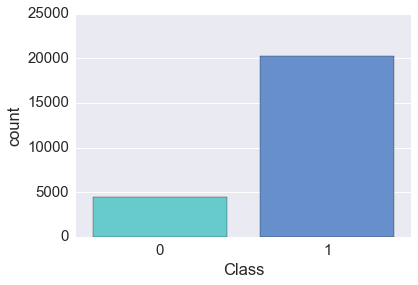

In [11]:
sns.countplot(df['Class'])

**To do: use over/under-sampling to balance true/false creditworthiness.**

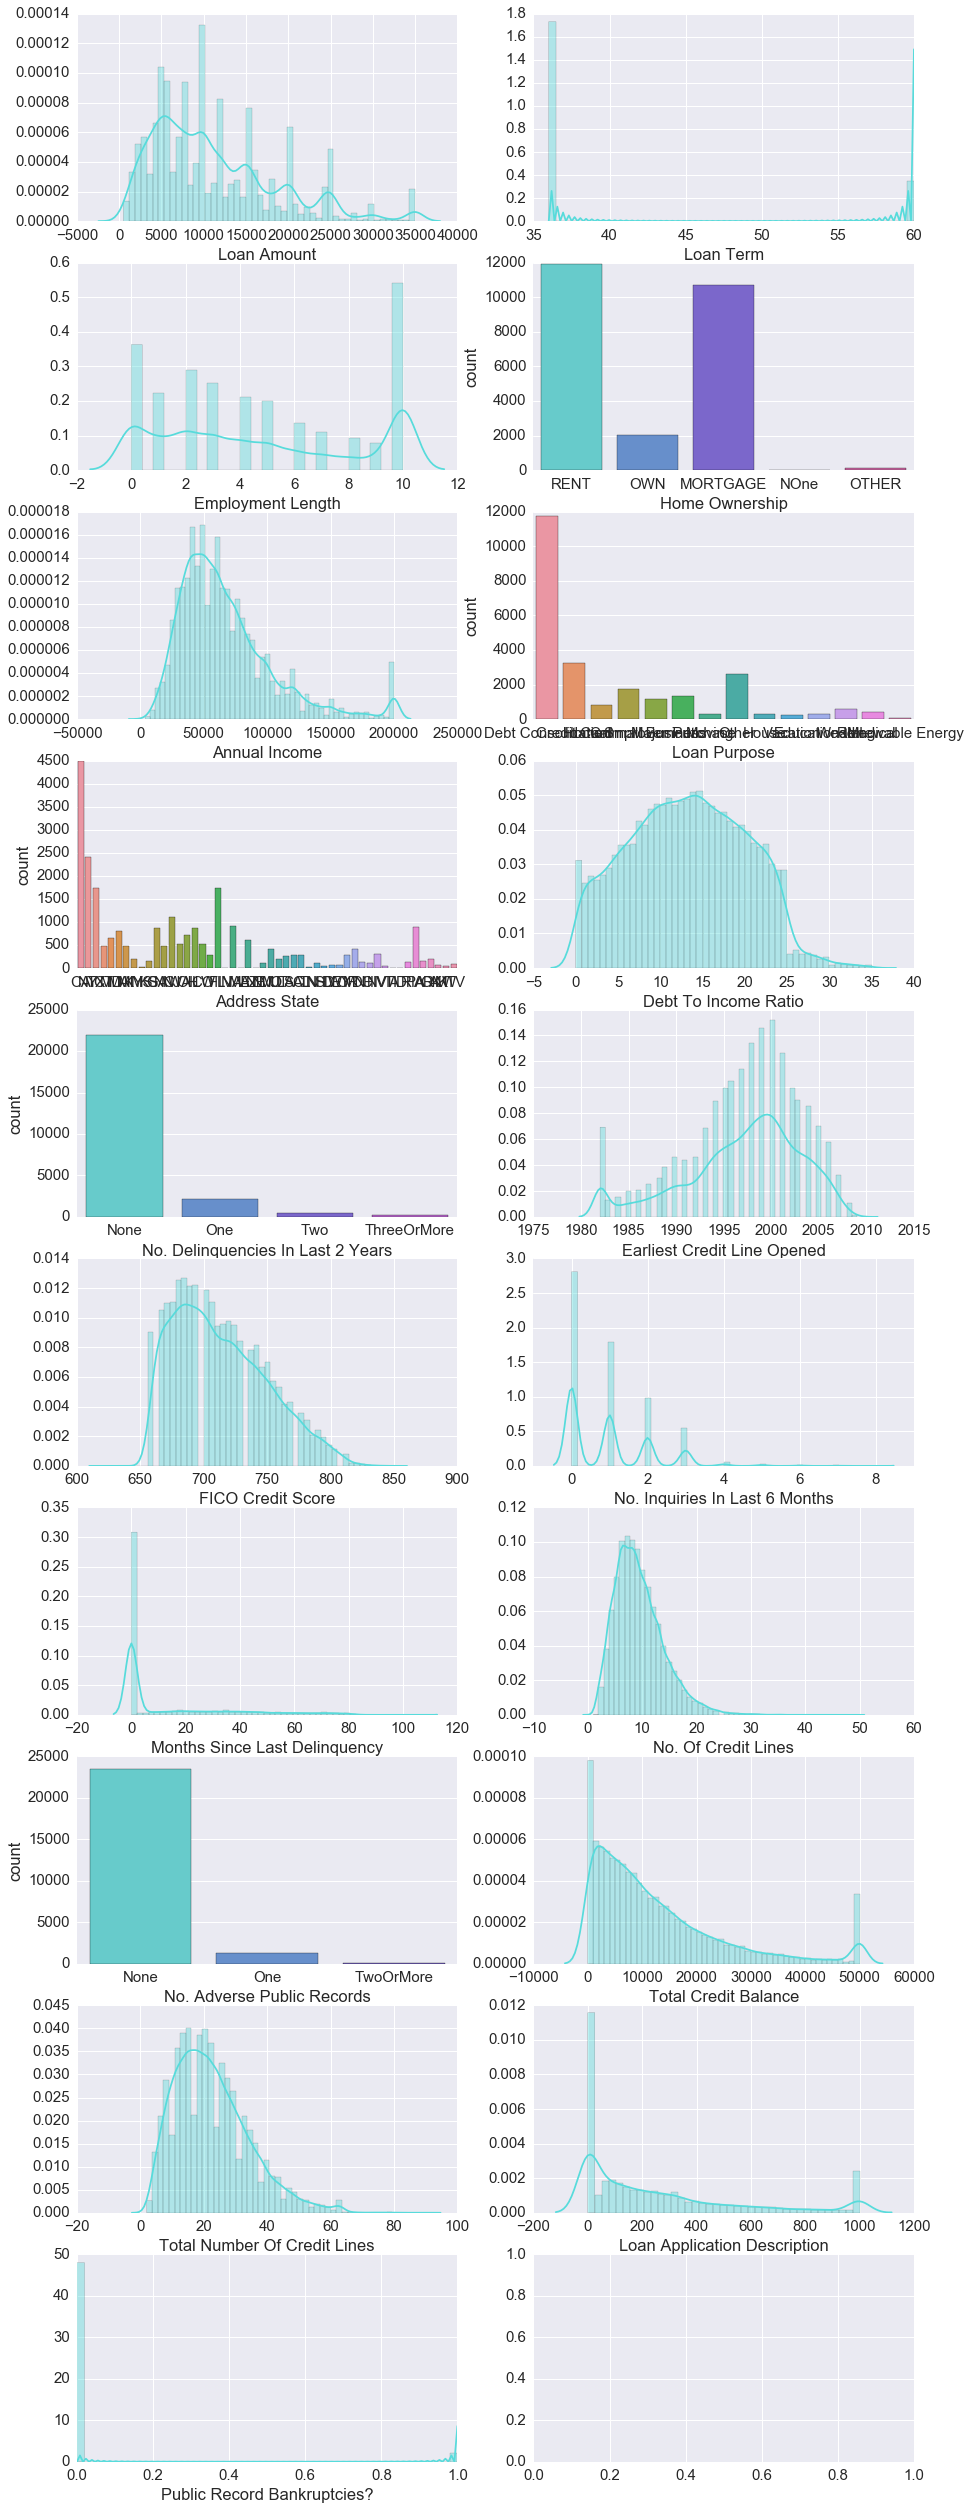

In [12]:
plot, axis_rows = plt.subplots(10, 2, figsize=(15, 40))
plot.subplots_adjust(bottom = 0.05)

dependent = 'Class'
tasks = zip(
    [c for c in df.columns if c not in [dependent, 'Use Of Credit Line']],
    [a for axes in axis_rows for a in axes]
    )

for column, ax in tasks:
    if df[column].dtype == np.object:
        sns.countplot(data=df, x=column, ax=ax)
    else:
        x = pd.to_numeric(df[column], errors='coerce')
        sns.distplot(x, ax=ax)

From the above, I can conclude:
1. I should look into *Home Ownership* values 'NOne' and 'OTHER' and perhaps aggregate.
2. I should determine whether 200,000 is a cap for *Annual Income* and, if so, whether binning is required.
3. I should determine whether 50,000 is a cap for *Total Credit Balance* and, if so, whether binning is required.
4. I should determine whether *Address State* has any predictive power and to aggregate approporiately either way.
5. I should consider transforming some of the numerical inputs with non-gaussian distributions, to help maintain the assumptions required for use of logistic regression.

##### Performing actions
Action 1: The Lending Club data dictionary suggests 'NOne' was not in their original data collection but does not specify what 'OTHER' is. I'll roll these together.

In [13]:
df['Home Ownership'].replace({'NOne': 'OTHER'}, inplace=True)
df['Home Ownership'].value_counts()

RENT        11924
MORTGAGE    10730
OWN          2019
OTHER         102
Name: Home Ownership, dtype: int64

Action 2/3: Given the limited time available and small proportion of the dataset affected, I'll leave both the capped *Annual Income* and *Total Credit Balance* features as is.

In [14]:
## Annual Income
print('Max annual income: {}'.format(max(df['Annual Income'])))
print('Capped uncreditworthy applicants: {}/{} ({:0.2f}%)'.format(
            sum(df['Annual Income'].loc[df['Class'] == 0] == 200000),
            sum(df['Class'] == 0),
            100 * sum(df['Annual Income'].loc[df['Class'] == 0] == 200000) / float(sum(df['Class'] == 0))
            ))
print('Capped creditworthy applicants: {}/{} ({:0.2f}%)'.format(
            sum(df['Annual Income'].loc[df['Class'] == 1] == 200000),
            sum(df['Class'] == 1),
            100 * sum(df['Annual Income'].loc[df['Class'] == 1] == 200000) / float(sum(df['Class'] == 1))
            ))

## Total Credit Balance
print('\nMax total credit balance: {}'.format(max(df['Total Credit Balance'])))
print('Capped uncreditworthy applicants: {}/{} ({:0.2f}%)'.format(
            sum(df['Total Credit Balance'].loc[df['Class'] == 0] == 50000),
            sum(df['Class'] == 0),
            100 * sum(df['Total Credit Balance'].loc[df['Class'] == 0] == 50000) / float(sum(df['Class'] == 0))
            ))
print('Capped creditworthy applicants: {}/{} ({:0.2f}%)'.format(
            sum(df['Total Credit Balance'].loc[df['Class'] == 1] == 50000),
            sum(df['Class'] == 1),
            100 * sum(df['Total Credit Balance'].loc[df['Class'] == 1] == 50000) / float(sum(df['Class'] == 1))
            ))

Max annual income: 200000.0
Capped uncreditworthy applicants: 52/4502 (1.16%)
Capped creditworthy applicants: 423/20273 (2.09%)

Max total credit balance: 50000.0
Capped uncreditworthy applicants: 122/4502 (2.71%)
Capped creditworthy applicants: 676/20273 (3.33%)


Action 4: To loosely assess the predictive power of the *Address State* field I plot the normalised counts from both classes. With the exception of those states with very few records, the *Class* by *Address State* is very similar. Note I'm not sure that the state a person resides in is indicative of their creditworthiness in itself - I would suggest that this is merely collinear with situational features depending on geography, e.g. net worth, employment history, etc. It may be that this is later removed from the model during feature selection for this reason.

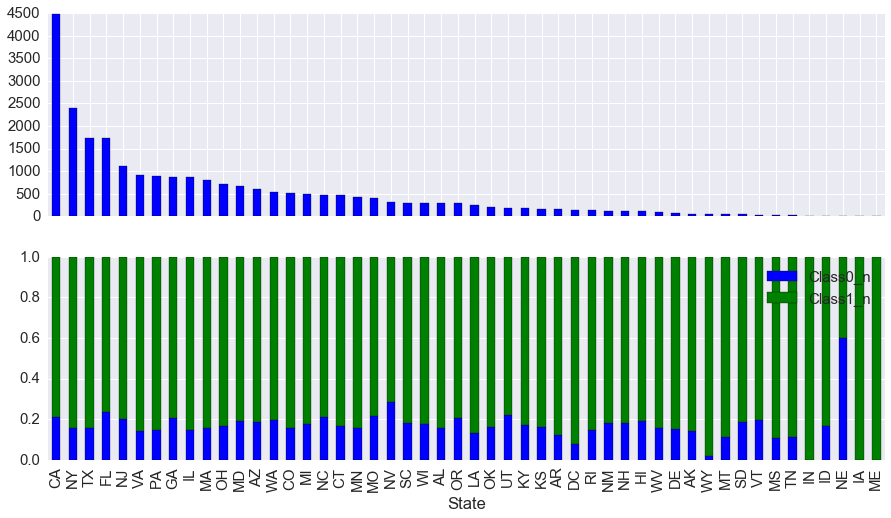

In [15]:
res = []
for s in df['Address State'].unique():
    res.append([s, 
                df['Address State'].loc[(df['Address State'] == s) & (df['Class'] == 0)].count(),
                df['Address State'].loc[(df['Address State'] == s) & (df['Class'] == 1)].count()
               ])
    
def normalise_2(x, y):
    return x / float(x + y)

res = pd.DataFrame(res, columns=['State', 'Class0', 'Class1'])
res['Class0_n'] = np.vectorize(normalise_2)(res['Class0'], res['Class1'])
res['Class1_n'] = 1 - res['Class0_n']
res['Count'] = res['Class0'] + res['Class1']
res.sort_values('Count', ascending=False, inplace=True)
res_count = res['Count']
res.drop(['Class0', 'Class1', 'Count'], axis=1, inplace=True)

# Plot with Seaborn and Pandas
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 8))
res_count.plot(kind='bar', ax=ax1)
res.plot(x=res['State'], kind='bar', stacked=True, ax=ax2)

**To do: Revisit *Address State* when performing feature selection. If low predictive power, remove.**

### 4) Assess dependent-independent variable relationships
Now that our data is in reasonable shape we can start reviewing the relationships between each feature and our dependent variable. I'd like to understand the predictive power of our features as they are, and aim to identify any particular nuances using a graphical representation. First, the numerical features:

In [16]:
binary_cols = ['Loan Term', 'Public Record Bankruptcies?', 'Class']
numerical_cols = [c for c in df.columns if (df[c].dtype == np.int64 or df[c].dtype == np.float64) and c not in binary_cols]
categorical_cols = [c for c in df.columns if c not in binary_cols and c not in numerical_cols]

#### Numerical features

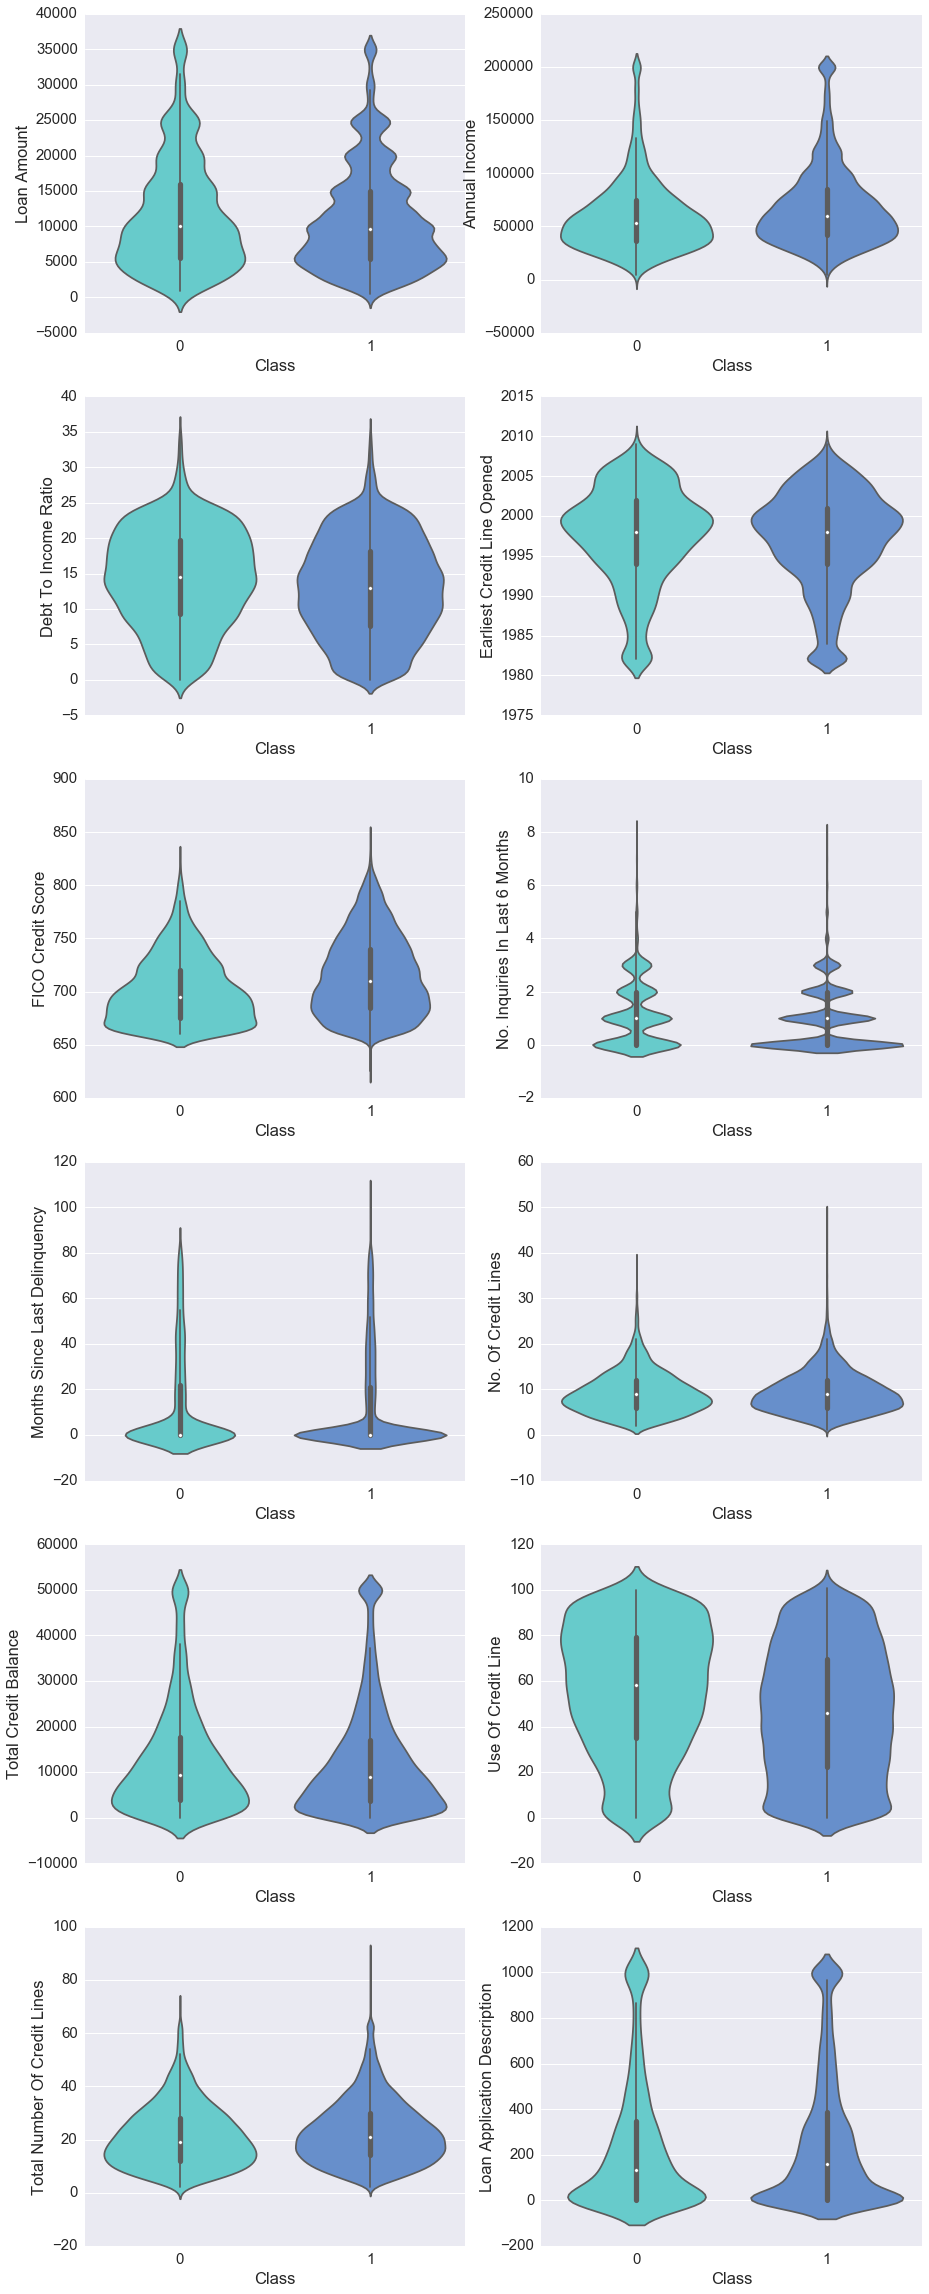

In [17]:
## Numerical features
plot, axis_rows = plt.subplots(len(numerical_cols) / 2, 2, figsize=(15, 40))

tasks = zip(
    numerical_cols,
    [a for axes in axis_rows for a in axes]
    )

for column, ax in tasks:
    sns.violinplot(data=df, y=column, x=dependent, ax=ax)

From the above I can conclude:
* Creditworthy applicants request a greater proportion of smaller loans, but generally the *Loan Amount* peaks are similar for both classes.
* Creditworthy applicants had a higher modal *Annual Income* than uncreditworthy applicants. They had a greater proportion of *Annual Income* >= 200,000, too, but this isn't very important.
* Uncreditworthy applicants were much more likely to have a higher *Debt to Income Ratio*.
* Uncreditworthy applicants were more likely to have a lower *FICO Credit Score*.
* Creditworthy applicants had a range of *Use of Credit Lines*, peaking at 5. Uncreditworthy applicants had a much higher usage, peaking at around 80. This could be a powerful predictor.
* Creditworthy applicants had a marginally greater *Total Number of Credit Lines* than uncreditworthy applicants. The data dictionary suggests this variable is both the number of open and closed credit lines in the borrower's file.
* *Loan Application Description* has a modestly, but discernably, different profile between the classes.

Other actions:
1. I should remove 'zero months' from *Months Since Last Delinquency* as this obscures its usefulness. Instead, I should use a binning system to show that zero is equivalent to 'N/A'.
2. Loan application description should be categorical.

##### Performing actions
Taking on action 1 from above, it appears the difference by *Class* is minor - indeed, this may not be a particularly predictive feature. After removing zeroes, it is difficult to tell the cases apart. For now I'll split into categorical bins, but it is likely this feature will later be removed during feature selection.

With only on the order of 10^4 rows, using dummies for all 10^3 loan application descriptions will bring us closer to issues with dimensionality. The Lending Club data dictionary is rather vague when explaining this feature, so I'm not sure whether it is a description from a fixed list of 10^3 options, the word count from an open textbox, etc. Given the problems with maintaining it I'll need to do something, so in this case I've opted for a binning system. As I know little about the feature, I'll use equal intervals.  

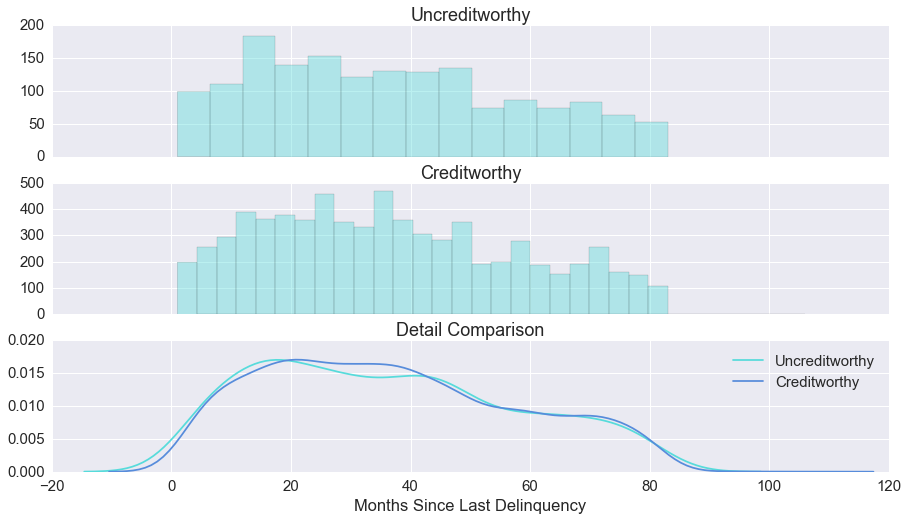

In [19]:
## Binning Months Since Last Delinquency
df_msld_0 = df['Months Since Last Delinquency'].loc[df['Class'] == 0]
df_msld_1 = df['Months Since Last Delinquency'].loc[df['Class'] == 1]
# Remove obscuring 'zero' values.
df_msld_0 = df_msld_0.loc[df['Months Since Last Delinquency'] > 0]
df_msld_1 = df_msld_1.loc[df['Months Since Last Delinquency'] > 0]
# Plot
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,8))
sns.distplot(df_msld_0, kde=False, ax=ax1)
sns.distplot(df_msld_1, kde=False, ax=ax2)
sns.distplot(df_msld_0, hist=False, ax=ax3, label='Uncreditworthy')
sns.distplot(df_msld_1, hist=False, ax=ax3, label='Creditworthy')
ax1.set(title='Uncreditworthy', xlabel='')
ax2.set(title='Creditworthy', xlabel='')
ax3.set(title='Detail Comparison', ylim=[0, 0.02])
ax3.legend()

# Use binning system for Months Since Last Delinquency, 0 -> 'NA'
min_not_zero = min(min(df_msld_0), min(df_msld_1), 0.25)
bins = [-0.25, min_not_zero * 0.99, 6, 12, 60, max(df['Months Since Last Delinquency'])]
labels = ['NA', 'x < 6', '6 < x < 12', '12< x < 60', 'x > 60']
df['Months Since Last Delinquency'] = pd.cut(x=df['Months Since Last Delinquency'], bins=bins, labels=labels)

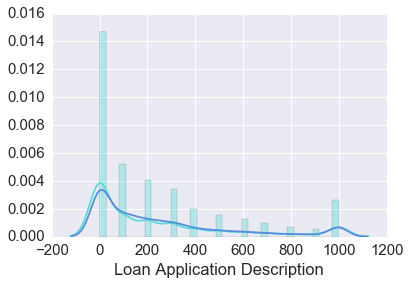

In [20]:
## Binning Loan Application Description
labels = [x for x in range(0, 1100, 100)]
df_lad = pd.cut(x=df['Loan Application Description'], bins=11, labels=labels)
# Plot
f, ax = plt.subplots(sharex=True)
sns.distplot(df_lad, ax=ax)
sns.distplot(df['Loan Application Description'], hist=False, kde=True, ax=ax)

# Use binning system for Loan Application Description
labels = ['x < 100', '100 < x < 200', '200 < x < 300', '300 < x < 400',
          '400 < x < 500', '500 < x < 600', '600 < x < 700', '700 < x < 800',
          '800 < x < 900', '900 < x < 1000', 'x > 1000']
df['Loan Application Description'] = pd.cut(x=df['Loan Application Description'], bins=11, labels=labels)

#### Categorical features

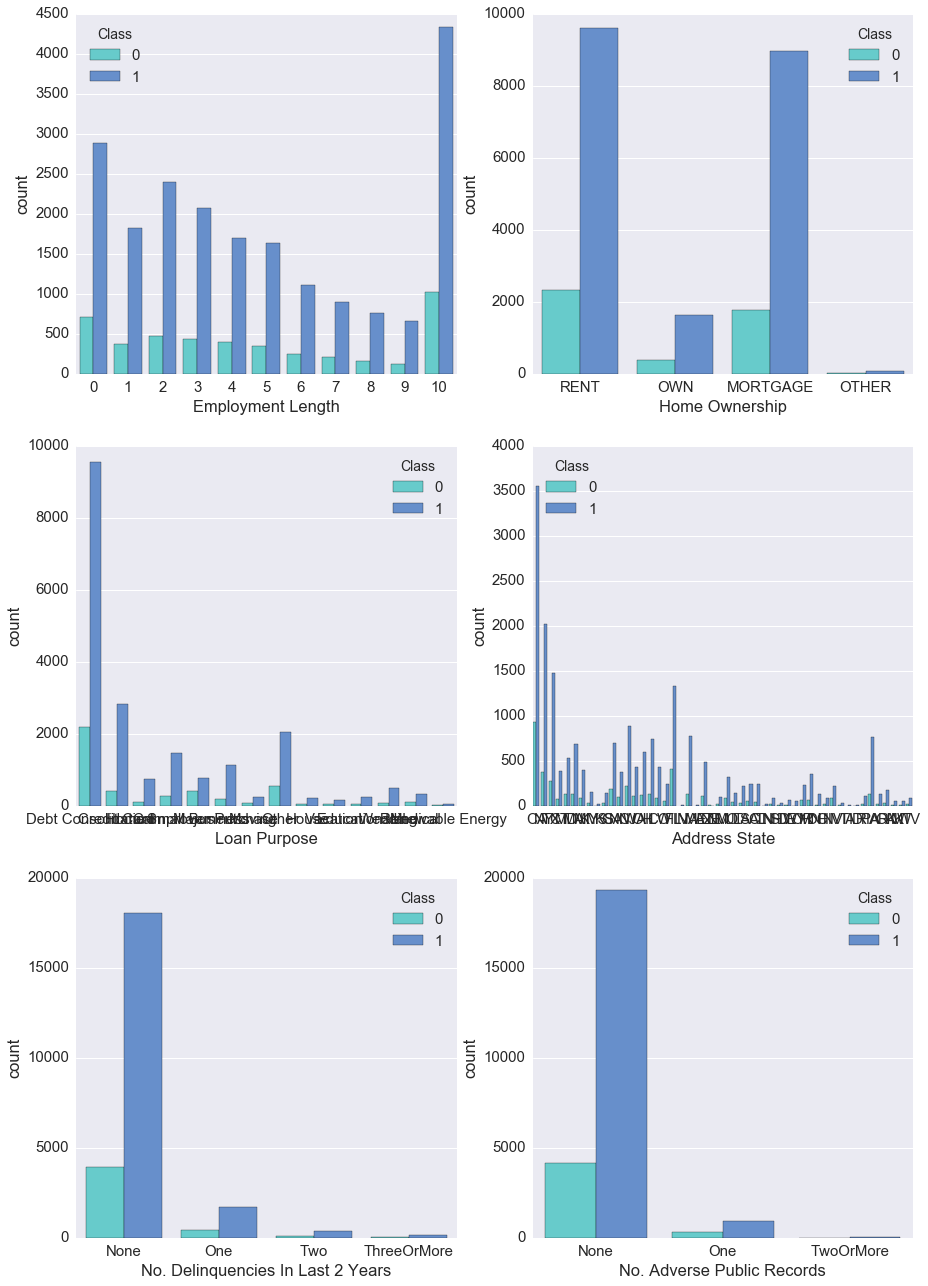

In [25]:
## Categorical features   
plot, axis_rows = plt.subplots(len(categorical_cols) / 2, 2, figsize=(15, 20))
plot.subplots_adjust(bottom = 0.05)

tasks = zip(
    categorical_cols,
    [a for axes in axis_rows for a in axes]
    )

for column, ax in tasks: 
    sns.countplot(data=df, x=column, hue=dependent, ax=ax)

The graphs above reveal that the categorical variables scale fairly independently of *Class*; no actions will be required until feature selection. Ideally the classes in these graphs would be normalised, but this will suffice as a quick check.

### Summary
** Cleaning steps performed:**
* Removed record index 7666.
* Converted *Employment Length* into 11 intervals.
* Mapped *Loan Term* to an integer. This could also be categorical and used with dummies.
* Mapped *No. Delinquencies In Last 2 Years* to use 'ThreeOrMore'.
* Mapped *No. Adverse Public Records* to use 'TwoOrMore'.
* Changed *No. Of Public Record Bankruptcies* to *Public Record Bankruptcies?* binary variable.
* Mapped *Class* to 0 (uncreditworthy) and 1 (creditworthy).
* Mapped *Earliest Credit Line Opened* to a year.
* Replaced 'NOne' with 'OTHER' in *Home Ownership*.
* Converted *Months Since Last Delinquency* into 5 non-equally spaced bins.
* Converted *Loan Application Description* into 11 intervals.

**To do:**
* Impute 51 missing values in 'Use of Credit Line' column.
* Revisit *Address State* when performing feature selection. If low predictive power, remove as likely to be collinear.
* Use over/under-sampling to balance true/false creditworthiness.

**If I have time:**
* Address capping of *Annual Income* and *Total Credit Balance*.
* Augmentation with LendingClub data?